In [3]:
import pandas as pd
from pathlib import Path
from PIL import Image 
import numpy as np

# Read data
data_path = Path(r"..\data\raw\Induced_Organism_Drift_2022")
df = pd.read_csv(r"..\data\raw\Induced_Organism_Drift_2022_annotations.csv")
df

,id,annotation_id,class,order,family,image,ind_id
0,1671,3596,Insecta,Ephemeroptera,Baetidae,11052022_T1_20025419_file12_frame96_box0_r.png,ID1
1,1672,3597,Insecta,Ephemeroptera,Baetidae,11052022_T1_20025419_file12_frame97_box0_r.png,ID1
2,1673,3598,Insecta,Ephemeroptera,Baetidae,11052022_T1_20025419_file12_frame98_box0_r.png,ID1
3,1674,3599,Insecta,Ephemeroptera,Baetidae,11052022_T1_20025419_file12_frame99_box0_r.png,ID1
4,1675,3600,Insecta,Ephemeroptera,Baetidae,11052022_T1_20025419_file12_frame100_box1_r.png,ID1
...,...,...,...,...,...,...,...
4593,325,2251,Insecta,Diptera,Diptera,11052022_T7_20025419_file30_frame386_box0_r.png,ID285
4594,326,2252,Insecta,Diptera,Diptera,11052022_T7_20025419_file30_frame387_box0_r.png,ID285
4595,327,2253,Insecta,Diptera,Diptera,11052022_T7_20025419_file30_frame388_box0_r.png,ID285
4596,328,2254,Insecta,Diptera,Diptera,11052022_T7_20025419_file30_frame389_box0_r.png,ID285


In [4]:
img_paths = df.image.apply(lambda x: data_path / x)
img_paths

0       C:\Users\DeSchaetzen\Desktop\benthic-models-ma...
1       C:\Users\DeSchaetzen\Desktop\benthic-models-ma...
2       C:\Users\DeSchaetzen\Desktop\benthic-models-ma...
3       C:\Users\DeSchaetzen\Desktop\benthic-models-ma...
4       C:\Users\DeSchaetzen\Desktop\benthic-models-ma...
                              ...                        
4593    C:\Users\DeSchaetzen\Desktop\benthic-models-ma...
4594    C:\Users\DeSchaetzen\Desktop\benthic-models-ma...
4595    C:\Users\DeSchaetzen\Desktop\benthic-models-ma...
4596    C:\Users\DeSchaetzen\Desktop\benthic-models-ma...
4597    C:\Users\DeSchaetzen\Desktop\benthic-models-ma...
Name: image, Length: 4598, dtype: object

In [5]:
from tqdm.notebook import tqdm
# Load images and convert to grayscale
X_list = []
for img_path in tqdm(img_paths):
    img = Image.open(img_path)
    if img.size != (250, 250):
        raise Exception
    else:
        X_list.append(np.array(img.convert("L")))

  0%|          | 0/4598 [00:00<?, ?it/s]

In [6]:
# Normalize from int 0-255 to float 0-1
X = np.array(X_list) / 255.
X.shape

(4598, 250, 250)

In [7]:
# Vectorize images
X = X.reshape(-1, 250*250)
X.shape

(4598, 62500)

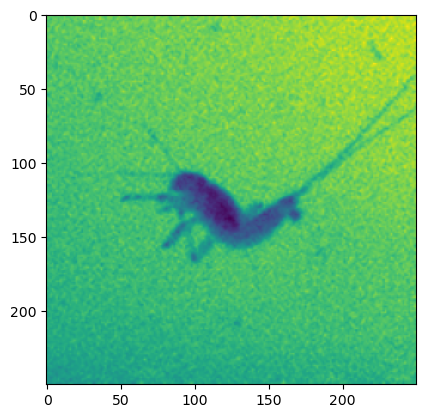

In [8]:
import matplotlib.pyplot as plt
# Sanity check that the shape is correct
plt.imshow(X[0].reshape(250,250))

In [35]:
from sklearn.decomposition import PCA
# Perform PCA
pca = PCA(n_components=16)
T = pca.fit_transform(X)

(0.0, 16.0)

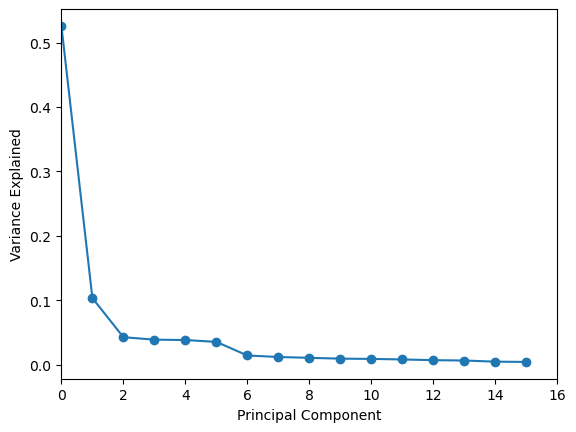

In [36]:
# Check eigenvalues
plt.plot(pca.explained_variance_ratio_, "o-")
plt.ylabel('Variance Explained')
plt.xlabel('Principal Component')
plt.xlim([0, 16])



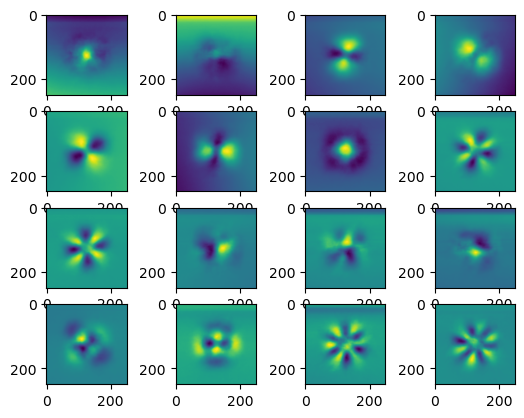

In [11]:
# Check eigenvectors in 2D
fig, axes = plt.subplots(4,4)
axes = [item for sublist in axes for item in sublist] # flatten ax list
for i in range(16):
    axes[i].imshow(pca.components_[i].reshape(250,250))

In [37]:
pca.explained_variance_ratio_

array([0.52615335, 0.10327201, 0.04250751, 0.03868552, 0.03813403,
       0.03520841, 0.0140824 , 0.01174148, 0.01044833, 0.00919096,
       0.00879483, 0.00794719, 0.00680566, 0.00628249, 0.00450678,
       0.00409834])

In [38]:
pca.explained_variance_

array([774.09366666, 151.93708442,  62.5384135 ,  56.91537089,
        56.10401324,  51.7997435 ,  20.71848466,  17.2744454 ,
        15.37191505,  13.52203291,  12.93923641,  11.6921552 ,
        10.0127098 ,   9.24299725,   6.6305264 ,   6.02961581])

We see, that the eigenvectors are very universal, finding only very high-level image features. The explained variance ratio in the first vectors is fairly low, as the images are very different looking.

We will see how the projections look next

In [89]:
# keep first 3 components
pca = PCA(n_components=16)
T = pca.fit_transform(X)

In [90]:
df = df.assign(pca_x = T[:,0],
               pca_y = T[:,1])

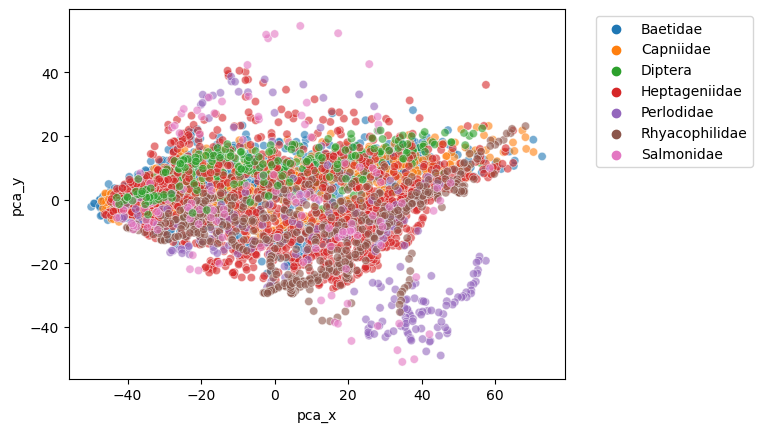

In [59]:
import seaborn as sns

sns.scatterplot(data=df,
                x="pca_x",
                y="pca_y",
                hue="family",
                alpha=0.6)
plt.legend(bbox_to_anchor=(1.05,1))

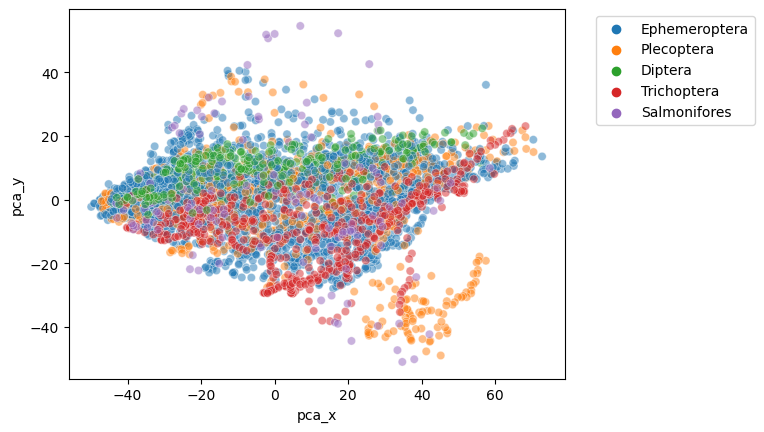

In [44]:
import seaborn as sns

sns.scatterplot(data=df,
                x="pca_x",
                y="pca_y",
                hue="order",
                alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1))

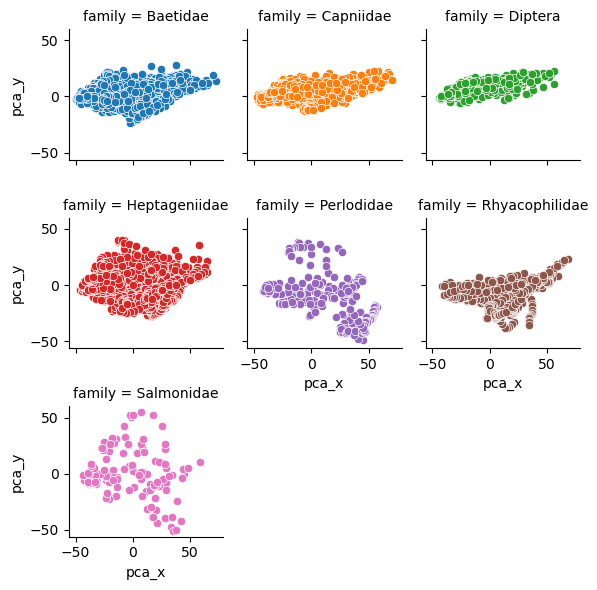

In [72]:
g = sns.FacetGrid(df, col="family", col_wrap=3, height=2, hue="family")
g.map(sns.scatterplot, "pca_x", "pca_y")

We see that the PCA projections clump together as the images are very similar, with some outliers.

In [73]:
import plotly.express as px

In [74]:
# Create interactive plot to find the outliers
px.scatter(df, x="pca_x", y="pca_y", hover_data=["id"])

# (Not visible in html)

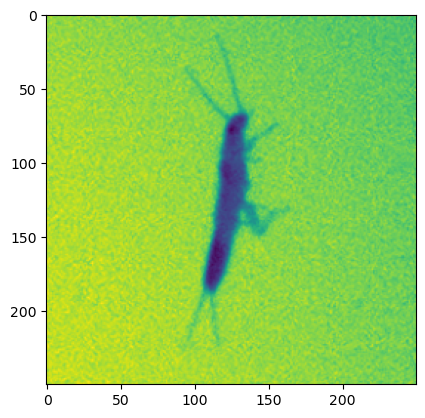

In [20]:
# Example from the "Main cluster"
plt.imshow(X[df.query("id==3387").index.values[0]].reshape(250,250))

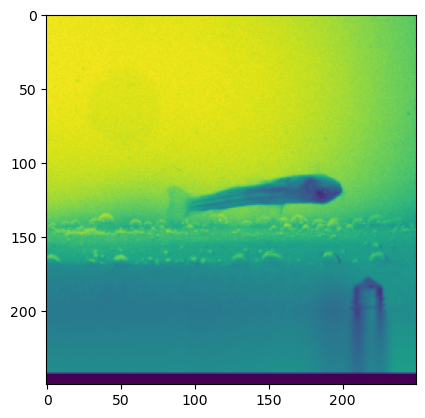

In [21]:
# Outlier from with the hightest second PC value
plt.imshow(X[df.query("id==4507").index.values[0]].reshape(250,250))

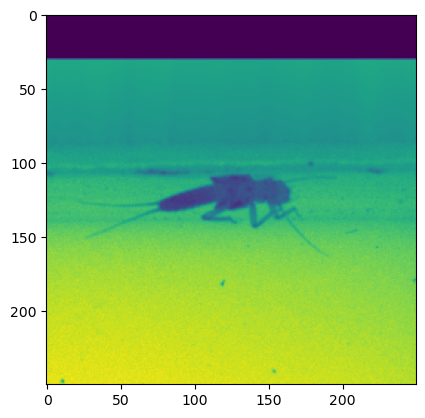

In [22]:
# Outlier from the "low" Plecoptera cluster
plt.imshow(X[df.query("id==3759").index.values[0]].reshape(250,250))

## Clustering

In [78]:
from sklearn.cluster import DBSCAN

In [152]:
# See cluster counts with different eps values
for eps in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]:
    clustering = DBSCAN(eps=eps).fit(T)
    print(len(pd.Series(clustering.labels_).value_counts()))

1
2
8
20
45
80
106
125
120
98
56
26
17
12
9
3


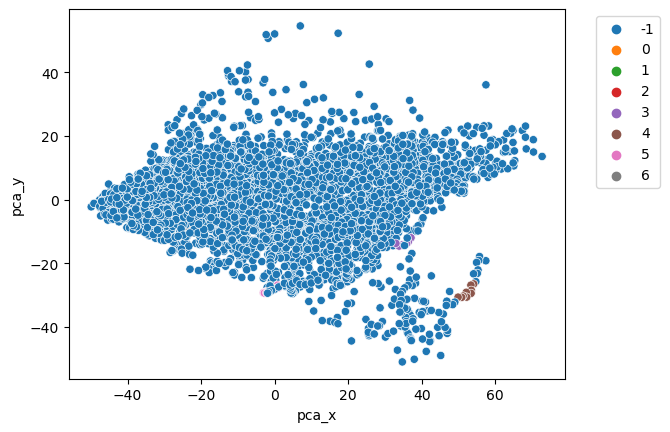

In [153]:
# Choose 3 as the best epsilon value that seems to find the clusters
clustering = DBSCAN(eps=3).fit(T)
df = df.assign(dbscan=clustering.labels_).astype({"dbscan":"category"})
sns.scatterplot(data=df,
                x="pca_x",
                y="pca_y",
                hue="dbscan")
plt.legend(bbox_to_anchor=(1.05,1))

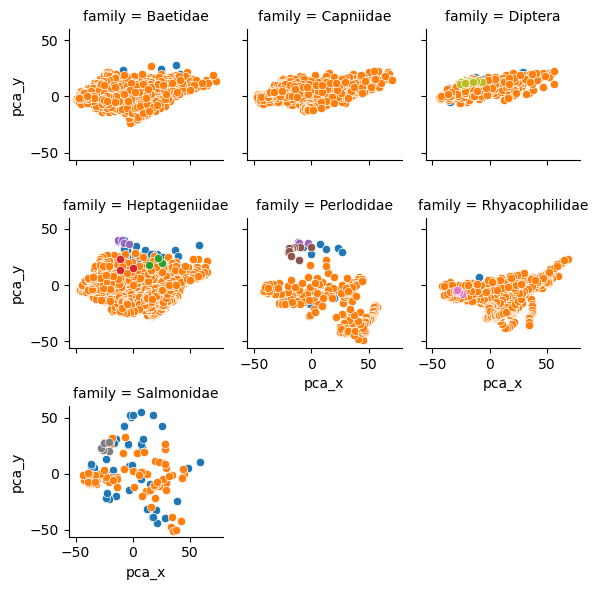

In [138]:
g = sns.FacetGrid(df, col="family", col_wrap=3, height=2, hue="dbscan")
g.map(sns.scatterplot, "pca_x", "pca_y")

We see, that the clusters do not match the actual classes very well.

Let's visualize the clusters

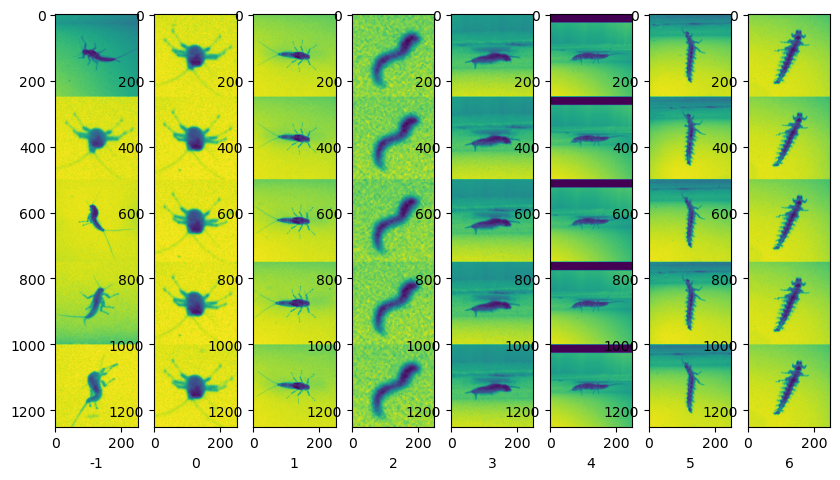

In [110]:
fig, axes = plt.subplots(1,len(df.dbscan.unique()), figsize=(10,10))
for i, c in enumerate(df.dbscan.unique()):
    df_clust = df.query("dbscan == @c")
    ind = df_clust.sample(5, replace = True).index.values
    axes[i].imshow(X[ind].reshape(5*250, 250))
    axes[i].set_xlabel(c)

As espected, PCA find images that are most similar looking on the raw pixel level, i.e. images with content in the same positions are clustered together. The clusters seem to contain most "normal" images (cluster 0), images that are taken on the bottom of the imager system (cluster 1), images at the top, with a black bar visible (cluster 2), images with a distinct gradient and horizontal specimen (cluster 3) and finally a very distinct cluster 4.


Just to double check, let's perform clustering with a different approach, the KMeans algorithm